In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [2]:
dataset = pd.read_csv("/Users/aimeexu/Desktop/W2021 DSU Weight Loss/dataset.csv")

In [3]:
dataset.head() # added 1 to "0 Calorie Columns"
dataset.shape

(894, 14)

In [16]:
train_calories, test_calories = train_test_split(dataset.Calories, test_size=0.2, random_state=42)
print(train_calories.head())

331    1377
735    3410
382    2236
706    1635
815    2505
Name: Calories, dtype: int64


In [17]:
# generate non-normal data
Y = dataset.Calories

# transform training data & save lambda value
train_calories_data,fitted_lambda = stats.boxcox(train_calories)
print(fitted_lambda)

0.7344905356107915


In [18]:
# use lambda value to transform test data
test_data = stats.boxcox(test_calories, fitted_lambda)

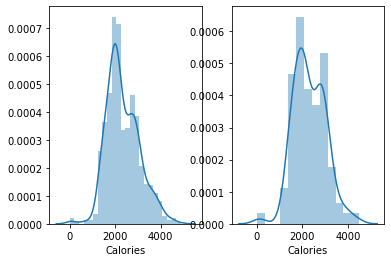

In [19]:
# plot train & test
fig, ax=plt.subplots(1,2)
sns.distplot(train_calories, ax=ax[0])
sns.distplot(test_calories, ax=ax[1])

In [20]:
calories_trans = dataset.Calories**fitted_lambda
calories_trans.head()

0    264.346694
1    245.716749
2    243.604385
3    240.473964
4    252.313444
Name: Calories, dtype: float64

In [21]:
# Append "Transformed Calories" to Dataset
df = pd.DataFrame(dataset)
df['Transformed Calories'] = calories_trans
df.head()

,Id,Date,TS,TD,LoggedAD,VAD,MAD,LAD,SAD,VAM,FAM,LAM,SM,Calories,Transformed Calories
0,1503960366,4/12/16,13162,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,264.346694
1,1503960366,4/13/16,10735,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,245.716749
2,1503960366,4/14/16,10460,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,243.604385
3,1503960366,4/15/16,9762,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,240.473964
4,1503960366,4/16/16,12669,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,252.313444


In [23]:
# Performing Linear Regression on New Data
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Shape of full *transformed dataset* is: {df.shape}")
print(f"Shape of training dataset is: {train.shape}")
print(f"Shape of test dataset is: {test.shape}")

Shape of full *transformed dataset* is: (894, 15)
Shape of training dataset is: (715, 15)
Shape of test dataset is: (179, 15)


In [25]:
# Use the training_data in bii to build 
# 7 predictors: (TS + TD + VAD + MAD + VAM + FAM + SM)
X_train1 = train[['TS', 'TD', 'VAD', 'MAD', 'VAM', 'FAM', 'SM' ]]
Y_train1 = train['Transformed Calories']

X_test1 = test[['TS', 'TD', 'VAD', 'MAD', 'VAM', 'FAM', 'SM' ]]
Y_test1 = test['Transformed Calories']

In [26]:
#Performing Linear Regression
regression = LinearRegression()
regression.fit(X_train1, Y_train1)
Y_pred1 = regression.predict(X_test1)

print('Intercept: \n', regression.intercept_)
print('Coefficients: \n', regression.coef_)

Intercept: 
 188.47218921521917
Coefficients: 
 [-3.42246874e-02  6.23015699e+01 -3.00862627e+01 -2.80220152e+01
  1.75433965e+00  9.24072722e-01  3.51673069e-02]


In [27]:
# R^2 and MSE
r2_test = regression.score(X_test1, Y_test1)
r2_train = regression.score(X_train1, Y_train1)
mse_test = mean_squared_error(Y_pred1, Y_test1)
mse_train = mean_squared_error(Y_train1, regression.predict(X_train1))

print(f'MSE of Test = {mse_test:.5}')
print(f'MSE of Train data = {mse_train:.5}')
print(f'R^2 of Test = {r2_test:.5}')
print(f'R^2 of Train = {r2_train:.5}') # I'm getting such a high MSE?

MSE of Test = 1619.9
MSE of Train data = 1189.2
R^2 of Test = 0.64336
R^2 of Train = 0.73966


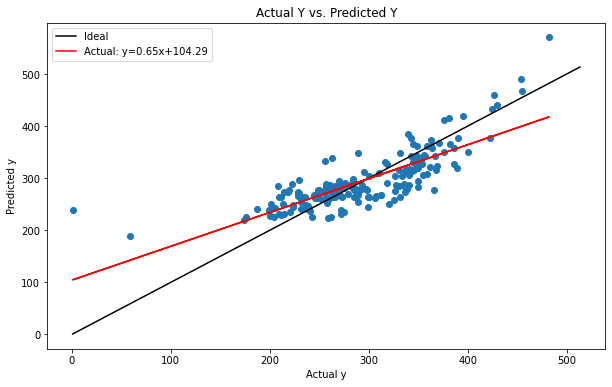

In [35]:
# Graphing Y_actual vs. Y_pred1
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(Y_test1, Y_pred1, 'o')
grid0 = np.linspace(np.min(calories_trans), np.max(calories_trans), 100)
ax.plot(grid0, grid0, color='black', label="Ideal") # 45 degree line
ax.set_xlabel("Actual y")
ax.set_ylabel("Predicted y")
ax.set_title("Actual Y vs. Predicted Y")

# plotting the best fit line
m, b = np.polyfit(Y_test1, Y_pred1, 1)
ax.plot(Y_test1, m*Y_test1 + b, color='red', label=f'Actual: y={m:.2f}x+{b:.2f}')

ax.legend()

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# check validity
prediction = regression.predict(X_train1)
residual = Y_train1 - prediction
print(f'Mean of Residuals: {residual.mean()}') 

# the independent variables set 
X = dataset[['TS', 'TD', 'VAD', 'MAD', 'VAM', 'FAM', 'SM' ]] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
  
print(vif_data) # My VIF is still super high, indicating collinearity...

Mean of Residuals: -3.808111557248537e-14
  feature         VIF
0      TS  153.758918
1      TD  167.468665
2     VAD    8.738766
3     MAD   16.797389
4     VAM    6.172128
5     FAM   17.429215
6      SM    2.949999
